# Implementing DeepVelo in mouse hippocampus development data

To compare cellDancer with other methods, this notebook shows the prediction of RNA velocity of [DeepVelo](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2) in mouse hippocampus development. We follow the preprocessing methods of [La Manno et al.](https://www.nature.com/articles/s41587-020-0591-3) to filter genes and cells. 18,140 cells with 2,159 genes were selected, which is the same as the datasets used in cellDancer. The input data could be downloaded from [DentateGyrus.h5ad](https:DentateGyrus.h5ad).

# Import packages

In [1]:
# %%
import numpy as np
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

import anndata as ann

from adata_to_df import adata_to_df
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

# Load mouse hippocampal dentate gyrus neurogenesis data

In [2]:
adata=ann.read_h5ad('your_path/DentateGyrus.h5ad')

# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
    "arch":{"args":{"pred_unspliced":True}}, 
    "n_gpu":0, # enable to use CPU
}
configs = update_dict(Constants.default_configs, configs)

scv.pp.neighbors(adata)

# initial velocity
velocity(adata, mask_zero=False)

trainer = train(adata, configs)

scv.tl.velocity_graph(adata, n_jobs=10) 

adata.write('your_path/DentateGyrus_pred_DeepVelo.h5ad')

The ratio of spliced reads is 71.2% (between 70% and 85%). Suggest using coeff_s 0.75.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([18140, 2159])
velo_mat shape: (18140, 2159)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)
computing velocity graph (using 10/48 cores)


  0%|          | 0/18140 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Visualize the phase portraits of sample genes

In [4]:
%%capture
adata=ann.read('your_path/DentateGyrus_pred_DeepVelo.h5ad')

# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_TSNE'] was added.
scv.pl.velocity_embedding(
    adata,
    basis="TSNE",
    arrow_length=6,
    arrow_size=1.2,
    dpi=300,
)

In [5]:
# transfer anndata to pandas dataframe
DeepVelo_esti_df_neuro=adata_to_df(adata,embed_para='X_TSNE',embed_pred_para='velocity_TSNE')
DeepVelo_esti_df_neuro

,gene_name,unsplice,splice,unsplice_predict,splice_predict,cellID,clusters,embedding1,embedding2,velocity1,velocity2
0,Rgs20,0.069478,0.021971,0.079374,0.024221,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429,0.051754,-0.027667
1,Rgs20,0.085834,0.016256,0.100202,0.016177,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895,0.057271,-0.024257
2,Rgs20,0.068644,0.047774,-0.134495,0.058629,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419,0.018970,0.024912
3,Rgs20,0.045387,0.018101,0.066092,0.033689,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485,-0.024255,0.046716
4,Rgs20,0.040457,0.012846,-0.033785,0.018862,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900,-0.008018,0.022513
...,...,...,...,...,...,...,...,...,...,...,...
39164255,Gpm6b,0.876650,1.276089,0.949939,1.353014,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668,0.055720,-0.032452
39164256,Gpm6b,2.024897,5.152006,2.416660,2.514644,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788,0.004808,0.009619
39164257,Gpm6b,1.848051,1.491445,1.684890,2.801641,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364,0.039807,0.035511
39164258,Gpm6b,0.696361,1.189091,0.730585,0.743554,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549,0.038980,-0.003169


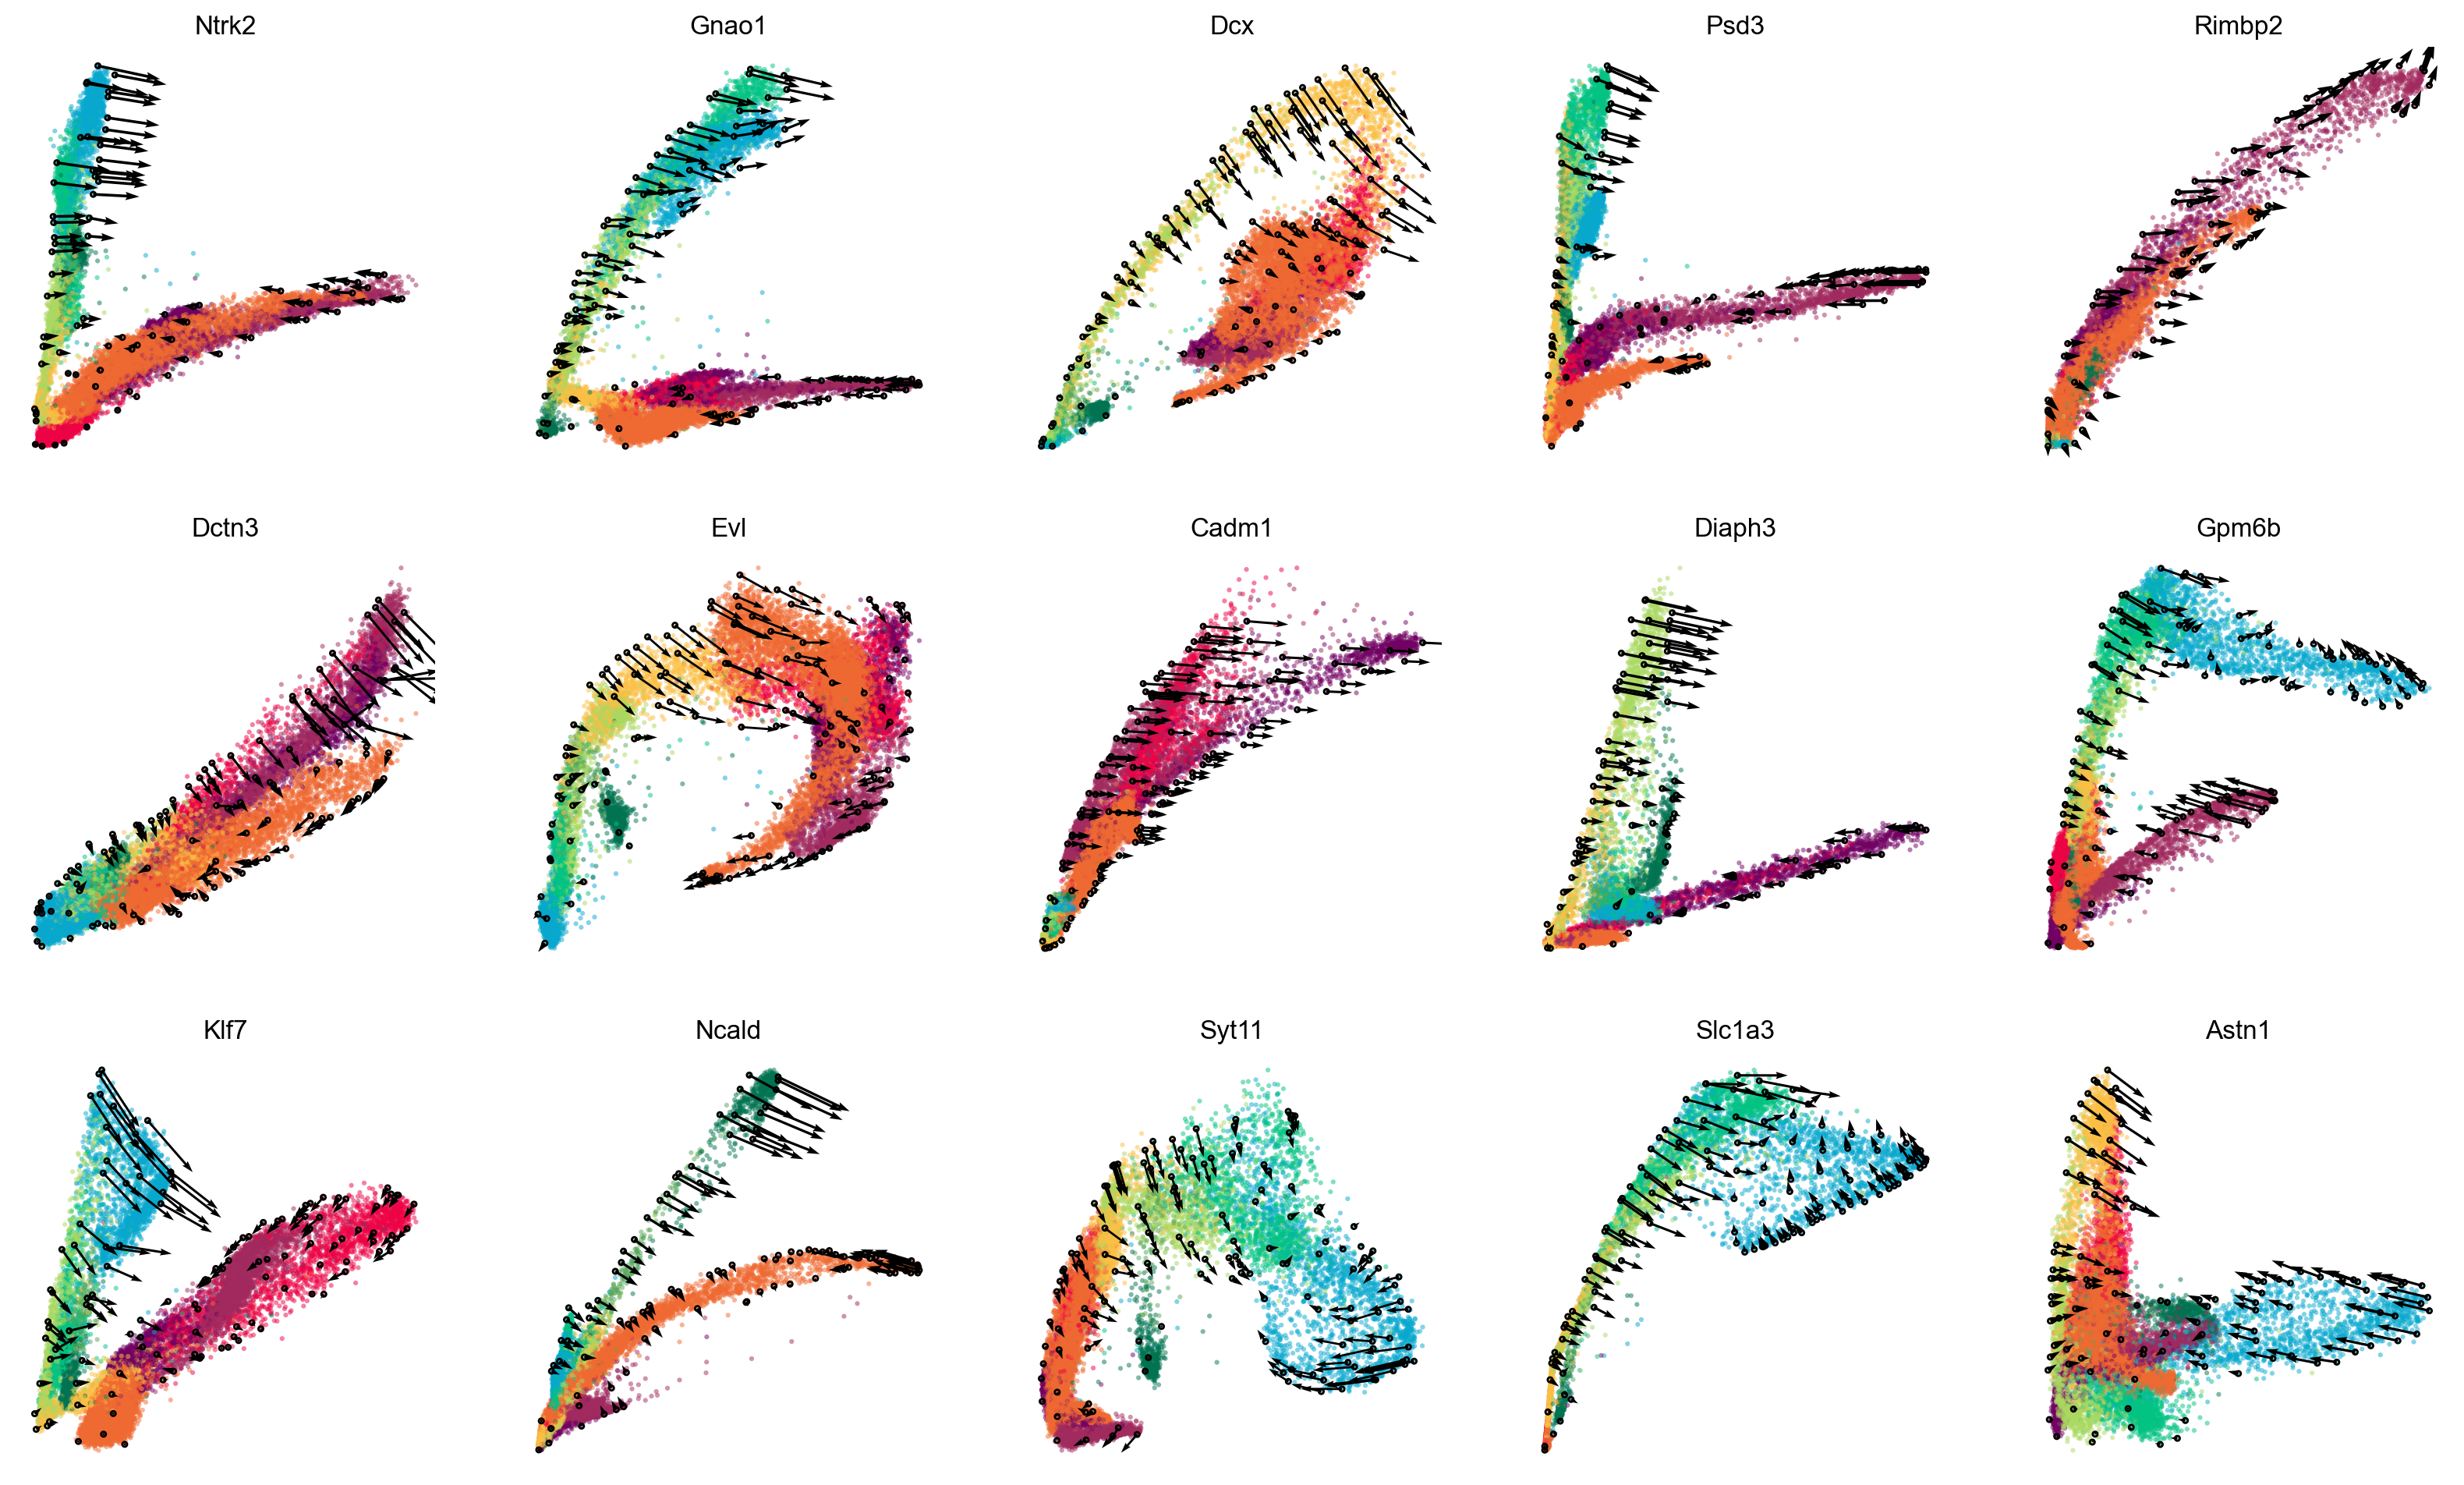

In [6]:
gene_list=['Ntrk2','Gnao1','Dcx','Psd3','Rimbp2','Dctn3','Evl','Cadm1','Diaph3','Gpm6b','Klf7','Ncald','Syt11','Slc1a3','Astn1']

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=DeepVelo_esti_df_neuro,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5,
        s = 5,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()